In [122]:
! pip3 install -U langchain_community langchain-openai langchain-anthropic langchain langgraph bs4

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


### Read File Function

In [123]:
def read_file(file_path):
  """Takes in a file path and reads that file line by line and returns the content as a string."""
  with open(file_path, 'r') as file:
    lines = file.readlines()
  return ''.join(lines)

### Write File Function

In [124]:
def write_file(file_path, file_content):
    """Takes in a file path and file content variable to write to the file"""
    with open(file_path, 'w') as file:
        file.write(file_content) 

### Reset original files 

In [137]:
dnm_original_xml = read_file(file_path="main_activity_layout_do_not_modify.xml")
dnm_original_main_activity = read_file(file_path="main_activity_do_not_modify.kt")

write_file(file_path="main_activity_layout.xml", file_content=dnm_original_xml)
write_file(file_path="main_activity.kt", file_content=dnm_original_main_activity)

## Read Migration & Files to Update

In [126]:
migrationInstructions = read_file(file_path="button_migration_doc.md")

to_migrate_array = ["main_activity_layout.xml", "main_activity.kt"]

### Setup Model for Structured Output

In [127]:
from pydantic import BaseModel, Field

# Data model
class code(BaseModel):
    """Schema for code outputs for migrations."""

    prefix: str = Field(description="Description of what was changed and why")
    code: str = Field(description="Entire code block with migrations performed")

In [128]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

## Uncomment to run
# _set_env("OPENAI_API_KEY")
# _set_env("ANTHROPIC_API_KEY")

### Model Set Up

In [129]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Prompt for code generation
code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in Android, Kotlin, and XML based UI. \n 
            You are tasked with migrating code for an Android project that impacts the XML UI and kotlin code. \n
            Here is documentation on the migration to be performed:  \n ------- \n  {context} \n ------- \n
            Migrate the provided code and output the entire class with the migrations peformed.\n
            Ensure that the code you provide only modifies what is necessary for the migration.\n
            Ensure all code that is output is ready to be executed.\n
            Structure your answer: 1) a prefix describing what you changed and why 2) The entire code block  \n
            Invoke the code tool to structure the output correctly. </instructions> \n Here is the migration to be performed:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt for code review
code_review_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding reviewer with expertise in Android, Kotlin, and XML based UI. \n 
            You are evaluating code tasked with migrating code for an Android project that impacts the XML UI and kotlin code. \n
            Here is documentation on the migration to be performed:  \n ------- \n  {context} \n ------- \n
            Review the provided code and ensure that all migrations are performed and everything else remains unmodified\n
            Provide feedback on the modifcations in list form.\n
            If everything looks correct, output: correct""",
        ),
        ("placeholder", "{messages}"),
    ]
)


expt_llm = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0, model=expt_llm)

# Code Gen Chain
code_gen_chain = code_gen_prompt | llm.with_structured_output(code)

# Code Review Chain 
code_review_chain = code_review_prompt | llm



In [130]:
# # Test
## Uncomment to run
# solution = code_gen_chain.invoke({"context": migrationInstructions, "messages": [("user", original_xml)]})
# solution

In [131]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int
    file_iteration: int = -1

In [132]:
### Parameter

# Max tries
max_iterations = 2
# Reflect
# flag = 'reflect'
flag = "do not reflect"

### Nodes

def file_selection(state: GraphState):
    """
    Prompts the LLM with the next file to be migrated

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """
    
    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]
    file_iteration = state["file_iteration"] + 1
    
    file_selected = to_migrate_array[file_iteration]
    print(f"---SELECTING FILE: {file_selected}---")
    
    opened_file = read_file(file_path=file_selected)
    # {"messages": [("user", original_xml)], "iterations": 0, "error": ""}
    return {"messages": [("user", opened_file)], "iterations": 0, "error": "", "file_iteration": file_iteration}
    
    
    

def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]
    file_iteration = state["file_iteration"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix and code block:",
            )
        ]

    # Solution
    print(f"---GENERATING CODE FOR FILE: {to_migrate_array[file_iteration]}")
    code_solution = code_gen_chain.invoke(
        {"context": migrationInstructions, "messages": messages}
    )
    
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations, "file_iteration": file_iteration}


def code_check(state: GraphState):
    """
    Check code against the migration guide ensuring that only the necessary changes were made.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---REVIEWING CODE FOR ACCURACY---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]
    file_iteration = state["file_iteration"]
    
    # TODO, run unit tests 
    
    review_output = code_review_chain.invoke(
        {"context": migrationInstructions, "messages": messages}
    )
    
    feedback = review_output.content
    
    feedback_error = "no"
    if(not feedback.endswith("correct")):
        feedback_error = "yes"
    
    messages += [("assistant", f"Here is feedback on the performed changes: {feedback}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations, "error":feedback_error, "file_iteration": file_iteration}


def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---REFLECT ON CODE SOLUTION & FEEDBACK---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]
    file_iteration = state["file_iteration"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": migrationInstructions, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the changes performed: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations, "file_iteration": file_iteration}


### Edges


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]
    file_iteration = state["file_iteration"]
    code_solution = state["generation"]

    if error != "yes" or iterations == max_iterations:
        # save current file 
        write_file(file_path=to_migrate_array[file_iteration], file_content=code_solution.code)
        
        if(file_iteration==len(to_migrate_array)-1):
            print("---DECISION: FINISH---")
            return "end"
        else:
            print("---DECISION: NEXT---")
            return "next"
       
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"

In [133]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("file_selection", file_selection)
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code", code_check)  # check code
workflow.add_node("reflect", reflect)  # reflect

# Build graph
workflow.add_edge(START, "file_selection")
workflow.add_edge("file_selection", "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "next":"file_selection",
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")
app = workflow.compile()

In [134]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	file_selection(file_selection)
	generate(generate)
	check_code(check_code)
	reflect(reflect)
	__end__([<p>__end__</p>]):::last
	__start__ --> file_selection;
	file_selection --> generate;
	generate --> check_code;
	reflect --> generate;
	check_code -. &nbsp;end&nbsp; .-> __end__;
	check_code -. &nbsp;next&nbsp; .-> file_selection;
	check_code -.-> reflect;
	check_code -.-> generate;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



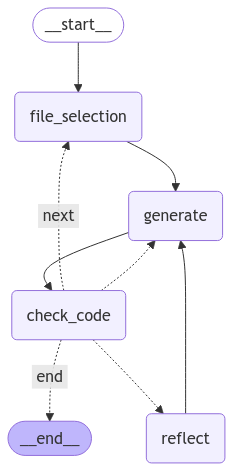

In [135]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [136]:
solution = app.invoke({"messages": [], "iterations": 0, "error": "", "file_iteration": -1})


solution

---SELECTING FILE: main_activity_layout.xml---
---GENERATING CODE FOR FILE: main_activity_layout.xml
---REVIEWING CODE FOR ACCURACY---
---DECISION: NEXT---
---SELECTING FILE: main_activity.kt---
---GENERATING CODE FOR FILE: main_activity.kt
---REVIEWING CODE FOR ACCURACY---
---DECISION: FINISH---


{'error': 'no',
 'messages': [('user',
   'package com.teegarcs.core_kotlin_android\n\nimport android.os.Bundle\nimport android.widget.Toast\nimport androidx.activity.viewModels\nimport androidx.appcompat.app.AppCompatActivity\nimport androidx.databinding.DataBindingUtil\nimport com.teegarcs.core_kotlin_android.databinding.ActivityMainBinding\nimport dagger.hilt.android.AndroidEntryPoint\n\n@AndroidEntryPoint\nclass MainActivity : AppCompatActivity() {\n\n    private val viewModel: MainViewModel by viewModels()\n\n    private lateinit var mBinding: ActivityMainBinding\n    override fun onCreate(savedInstanceState: Bundle?) {\n        super.onCreate(savedInstanceState)\n        mBinding = DataBindingUtil.setContentView(this, R.layout.activity_main)\n        mBinding.lifecycleOwner = this\n        mBinding.viewModel = viewModel\n\n        //show an error any time this is hit.\n        viewModel.errorLiveData.observe(this, {\n            val toast = Toast.makeText(\n                applic